In [1]:
# ===================================================================================
# 1) SETUP, DATA LOADING, CLEANING, และ PREPROCESSING (พร้อมการเสริมข้อมูลให้สมดุล)
# ===================================================================================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import joblib
from typing import Dict, Any

# -------------------------
# การตั้งค่าฟอนต์ภาษาไทย และ ค่าคงที่
# -------------------------
THAI_FONT = 'Tahoma' 
try:
    font_path = fm.findfont(fm.FontProperties(family=THAI_FONT))
    font_prop = fm.FontProperties(fname=font_path, size=14)
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['axes.unicode_minus'] = False 
    print(f"✅ ตั้งค่าฟอนต์สำเร็จแล้ว: กำหนดให้ใช้ฟอนต์ '{font_prop.get_name()}'")
except Exception as e:
    print(f"❌ WARNING: ไม่สามารถตั้งค่าฟอนต์ภาษาไทย '{THAI_FONT}' ได้ ({e}). ใช้ฟอนต์เริ่มต้น.")

NUM_EXPECTED_CLASSES = 9
# เกณฑ์ที่ใช้ใน Rule-Based
VOLT_LOW_THRESHOLD = 18.0   
TEMP_HIGH_THRESHOLD = 50.0  
DUST_HIGH_THRESHOLD = 150.0 
LIGHT_LOW_THRESHOLD = 200.0 
VOLT_CRITICAL_LOW = 0.0     

AI_CLASS_MAPPING: Dict[int, str] = {
    0: "ปกติ", 
    1: "ฝุ่น", 
    2: "อุณหภูมิสูง", 
    3: "เงาบัง",
    4: "Sensor Error / ค่าผิดปกติเกินขอบเขต", 
    5: "ร้อน+เงา", 
    6: "ฝุ่น+ร้อน",
    7: "ฝุ่น+เงา", 
    8: "ฝุ่น+ร้อน+เงา"
}


# -------------------------
# 1.1) โหลดและรวมไฟล์ข้อมูลเดิม
# -------------------------
file_paths = ["sensor_data.csv", "SENSOR2.CSV", "full_synthetic_data_v2.csv"]
all_data = []

print("\n--- 1.1) Data Loading and Cleaning ---")
for file_path in file_paths:
    try:
        df = pd.read_csv(file_path)
        df.rename(columns={'voltage(V)': 'Voltage', 'dust(ug/m3)': 'Dust', 'light(lx)': 'Irradiance', 'temp(C)': 'Temperature'}, inplace=True)
        for col in ['Voltage', 'Dust', 'Irradiance', 'Temperature']:
             df[col] = pd.to_numeric(df[col], errors='coerce')
        all_data.append(df)
    except FileNotFoundError:
        print(f"❌ ERROR: ไม่พบไฟล์ '{file_path}'")

data_raw = pd.concat(all_data, ignore_index=True)
data_raw.dropna(inplace=True)
print(f"\nTotal rows from original files after initial cleaning: {len(data_raw)}")


# ----------------------------------------------------
# 1.2) ฟังก์ชัน Rule-Based สำหรับสร้าง Label (10 Classes)
# ----------------------------------------------------
def create_multi_class_labels(row):
    # ตัวแปรสถานะความผิดปกติเบื้องต้น
    is_dusty = row["Dust"] > DUST_HIGH_THRESHOLD
    is_hot = row["Temperature"] > TEMP_HIGH_THRESHOLD
    # >>> เพิ่มบรรทัดนี้: <<<
    is_cold = row["Temperature"] < TEMP_LOW_THRESHOLD
    is_shady = row["Irradiance"] < LIGHT_LOW_THRESHOLD
    is_night = row["Irradiance"] < 10

    # ====================================================================
    # 1. PRIORITY 1: Sensor Error / ค่าผิดปกติเกินขอบเขต (Class 4)
    #    (ป้องกันค่า error หรือค่าที่ไม่สมเหตุสมผลทางกายภาพ)
    # ====================================================================
    is_physical_outlier = (
        # ตรวจสอบ Voltage: สูงเกิน 18V หรือต่ำผิดปกติ (เช่น ติดลบ)
        row["Voltage"] > 18.0 or row["Voltage"] < -1.0 or
        # ตรวจสอบ Dust: ต่ำกว่า 0 หรือสูงเกิน 1000 ug/m3
        row["Dust"] < 0 or row["Dust"] > 1000 or
        # ตรวจสอบ Temperature: ต่ำกว่า -50C หรือสูงเกิน 60C (<<< ต้องแก้เงื่อนไข Temperature ตรงนี้ด้วย)
        # **แก้ไข** บรรทัดนี้:
        row["Temperature"] < 0 or row["Temperature"] > 50 or 
        # ตรวจสอบ Irradiance: ต่ำกว่า -10 lx หรือสูงเกิน 2000 lx
        row["Irradiance"] < -10 or row["Irradiance"] > 2000
    )
    
    # ตรวจสอบ Volt ต่ำวิกฤต (มักเป็น Sensor/Internal Error หากไม่มีปัจจัยภายนอก)
    is_critical_low_volt = (
        row["Voltage"] < VOLT_CRITICAL_LOW and 
        not is_dusty and not is_hot and not is_shady and not is_night
    )

    if is_physical_outlier or is_critical_low_volt:
        return 4 # Class 4: Sensor Error / Outlier (หยุดการทำงานทันที)

    # ====================================================================
    # 2. PRIORITY 2: Normal / Night (Class 0)
    #    (เมื่อผ่านการตรวจสอบ Class 4 มาแล้ว จึงตรวจสอบภาวะปกติ)
    # ====================================================================
    if row["Voltage"] > VOLT_LOW_THRESHOLD: 
        return 0 # Volt ปกติ (เกิน 16V)
    if is_night: 
        return 0 # กลางคืน (แสงน้อยมาก)

    # ====================================================================
    # 3. PRIORITY 3: Combinations (Classes 8, 6, 7, 5) และ Single Faults (1, 2, 3)
    # ====================================================================
    if is_dusty and is_hot and is_shady: return 8
    elif is_dusty and is_hot: return 6
    elif is_dusty and is_shady: return 7
    elif is_hot and is_shady: return 5
    elif is_dusty: return 1
    elif is_hot: return 2
    elif is_shady: return 3
    
    # Fallback/Residual: ถ้า Volt ต่ำกว่าเกณฑ์ (16V) และไม่มีเงื่อนไขอื่น ๆ เลย 
    if row["Voltage"] <= VOLT_LOW_THRESHOLD: 
        return 3 # ถือว่าเป็นเงาบังเล็กน้อย (Shadowing)
        
    return 0

# -----------------------------------------------------
# 1.3) เสริมข้อมูลสังเคราะห์ให้ทุก Class มีอย่างน้อย 4,000 ตัวอย่าง (และเพิ่ม Noise)
# -----------------------------------------------------
print("\n--- 1.3) Augmenting Data for Class Balance (Min 4000 Samples/Class) ---")

MIN_SAMPLES_PER_CLASS = 4000 
np.random.seed(42)

data = data_raw.copy()
data["Label"] = data.apply(create_multi_class_labels, axis=1) 
class_counts = data["Label"].value_counts().sort_index()

synthetic_data_list = []

print("Class counts before augmentation:")
print(class_counts.to_string())
print("-" * 35)

for class_id in range(NUM_EXPECTED_CLASSES):
    current_count = class_counts.get(class_id, 0)
    N_TO_ADD = MIN_SAMPLES_PER_CLASS - current_count
    
    if N_TO_ADD > 0:
        class_data = data[data['Label'] == class_id]
        
        if len(class_data) > 0:
            # Resampling และเพิ่ม Noise (ปรับจาก 0.01 เป็น 0.03 เพื่อเพิ่มความหลากหลาย)
            samples = class_data.sample(n=N_TO_ADD, replace=True, random_state=42)
            noise_factor = 0.03 # <<< แก้ไขตรงนี้
            
            # การสร้าง Noise 
            # เราใช้ mean ของข้อมูลเดิมมาคูณกับ noise factor เพื่อให้ noise มี scale ที่เหมาะสม
            noise = (np.random.randn(N_TO_ADD, 4) * samples[["Voltage", "Temperature", "Dust", "Irradiance"]].mean().values * noise_factor)
            
            augmented_samples = samples.copy()
            augmented_samples[["Voltage", "Temperature", "Dust", "Irradiance"]] += noise
            augmented_samples["Label"] = class_id 
            synthetic_data_list.append(augmented_samples)
            print(f"➕ Augmenting Class {class_id} ({AI_CLASS_MAPPING[class_id]}): Added {N_TO_ADD} samples.")

        else:
            # สร้างข้อมูลใหม่ทั้งหมด (สำหรับ Class ที่ไม่มีอยู่เลย)
            N_TO_ADD = MIN_SAMPLES_PER_CLASS 
            
            # Class 8: ฝุ่น+ร้อน+เงา (Worst Case)
            if class_id == 8: 
                 new_samples = pd.DataFrame({
                    "Voltage": np.random.uniform(5.0, 14.0, N_TO_ADD),
                    "Temperature": np.random.uniform(55.0, 65.0, N_TO_ADD),
                    "Dust": np.random.uniform(200.0, 600.0, N_TO_ADD),
                    "Irradiance": np.random.uniform(10.0, 150.0, N_TO_ADD),
                    "Label": 8
                 })
                 synthetic_data_list.append(new_samples)
                 print(f"🆕 Creating Class 8 (Worst Case): Added {N_TO_ADD} new samples.")

            # Class 4: Sensor Error/Outlier (Volt ต่ำวิกฤต)
            elif class_id == 4: 
                 new_samples = pd.DataFrame({
                    "Voltage": np.random.uniform(0.0, VOLT_CRITICAL_LOW - 1.0, N_TO_ADD),
                    "Temperature": np.random.uniform(25.0, 40.0, N_TO_ADD),
                    "Dust": np.random.uniform(10.0, 100.0, N_TO_ADD),
                    "Irradiance": np.random.uniform(300.0, 1500.0, N_TO_ADD),
                    "Label": 4
                 })
                 synthetic_data_list.append(new_samples)
                 print(f"🆕 Creating Class 4 (Sensor Error): Added {N_TO_ADD} new samples.")
            
# -----------------------------------------------------
# 1.4) รวมข้อมูลทั้งหมดและเตรียมสำหรับ Training
# -----------------------------------------------------
if synthetic_data_list:
    data_augmented = pd.concat(synthetic_data_list, ignore_index=True)
    data = pd.concat([data, data_augmented], ignore_index=True)
    data.drop_duplicates(inplace=True)
    
    print("\nClass counts after augmentation:")
    print(data["Label"].value_counts().sort_index().to_string())


# บันทึกเป็นไฟล์ CSV ใหม่
OUTPUT_FILENAME = "final_balanced_augmented_data_4000.csv"
data[["Voltage", "Temperature", "Dust", "Irradiance", "Label"]].to_csv(OUTPUT_FILENAME, index=False)
print(f"\n🎉 **ไฟล์ '{OUTPUT_FILENAME}' ถูกสร้างแล้ว** (ทุก Class มีอย่างน้อย 4,000 ตัวอย่าง)")

# Features (X) และ Target (y)
X = data[["Voltage", "Temperature", "Dust", "Irradiance"]].values
y = data["Label"].values

# สเกลข้อมูล X (StandardScaler) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# แปลง Label y เป็น One-Hot Encoding 
all_possible_classes = np.arange(NUM_EXPECTED_CLASSES).reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False, categories=[all_possible_classes.flatten()])
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

# Train/Test Split (70% / 30%)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y 
)

print(f"\nTraining set size: {X_train.shape[0]} samples (70%)")
print(f"Test set size: {X_test.shape[0]} samples (30%)")

✅ ตั้งค่าฟอนต์สำเร็จแล้ว: กำหนดให้ใช้ฟอนต์ 'Tahoma'

--- 1.1) Data Loading and Cleaning ---

Total rows from original files after initial cleaning: 73623

--- 1.3) Augmenting Data for Class Balance (Min 4000 Samples/Class) ---
Class counts before augmentation:
Label
0     9871
1     1627
2     1596
3     3289
4    52227
5     1659
6     1625
7     1729
-----------------------------------
➕ Augmenting Class 1 (ฝุ่น): Added 2373 samples.
➕ Augmenting Class 2 (อุณหภูมิสูง): Added 2404 samples.
➕ Augmenting Class 3 (เงาบัง): Added 711 samples.
➕ Augmenting Class 5 (ร้อน+เงา): Added 2341 samples.
➕ Augmenting Class 6 (ฝุ่น+ร้อน): Added 2375 samples.
➕ Augmenting Class 7 (ฝุ่น+เงา): Added 2271 samples.
🆕 Creating Class 8 (Worst Case): Added 4000 new samples.

Class counts after augmentation:
Label
0     9871
1     4000
2     4000
3     4000
4    52219
5     4000
6     4000
7     4000
8     4000

🎉 **ไฟล์ 'final_balanced_augmented_data_4000.csv' ถูกสร้างแล้ว** (ทุก Class มีอย่างน้อย 4,000 ตัว

In [2]:
# ===================================================================================
# 2) MODEL CREATION AND TRAINING (DNN)
# ===================================================================================

print("\n" + "="*50)
print("--- 2) Model Creation and Training (DNN) ---")
print("="*50)

# สร้างโมเดล (ปรับโครงสร้างให้ซับซ้อนขึ้นเพื่อเพิ่มความแม่นยำ)
model = keras.Sequential([
    # Layer 1: เพิ่ม Neurons เป็น 128
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)), 
    layers.Dropout(0.2),
    # Layer 2: เพิ่มชั้นใหม่
    layers.Dense(64, activation='relu'), 
    # Layer 3: ชั้นเดิม
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(NUM_EXPECTED_CLASSES, activation='softmax') 
])

# Compile และฝึกโมเดล 
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train, 
    epochs=100, # <<< แก้ไขตรงนี้ (เพิ่มจาก 50 เป็น 100)
    batch_size=32, 
    validation_data=(X_test, y_test),
    verbose=1
)

# บันทึก Model และ Scaler 
model.save('solar_diagnosis_model_9class_high_accuracy.h5')
joblib.dump(scaler, 'solar_diagnosis_scaler_high_accuracy.pkl')
print("\n✅ Model และ Scaler ถูกบันทึกแล้ว")


--- 2) Model Creation and Training (DNN) ---
Epoch 1/100


C:\Users\pc com\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1971/1971 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9324 - loss: 0.1977 - val_accuracy: 0.9987 - val_loss: 0.0106
Epoch 2/100
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9927 - loss: 0.0258 - val_accuracy: 0.9983 - val_loss: 0.0055
Epoch 3/100
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9954 - loss: 0.0146 - val_accuracy: 0.9990 - val_loss: 0.0031
Epoch 4/100
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9973 - loss: 0.0094 - val_accuracy: 0.9993 - val_loss: 0.0016
Epoch 5/100
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9974 - loss: 0.0086 - val_accuracy: 0.9987 - val_loss: 0.0029
Epoch 6/100
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9975 - loss: 0.0079 - val_accuracy: 0.9993 - val_loss: 0.0021
Epoch 7/100
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.9944 - val_loss: 0.0172
Epoch 8/100
1971/1971 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9976 - loss: 0.0072 - val_


✅ Model และ Scaler ถูกบันทึกแล้ว



--- 3) Model Evaluation ---
Test Loss: 0.0016
Test Accuracy: 0.9994

Classification Report (ความแม่นยำของแต่ละ Class):
                                     precision    recall  f1-score   support

                               ปกติ       1.00      1.00      1.00      2961
                               ฝุ่น       1.00      1.00      1.00      1200
                        อุณหภูมิสูง       0.99      1.00      1.00      1200
                             เงาบัง       1.00      0.99      1.00      1200
Sensor Error / ค่าผิดปกติเกินขอบเขต       1.00      1.00      1.00     15666
                           ร้อน+เงา       1.00      1.00      1.00      1200
                          ฝุ่น+ร้อน       1.00      1.00      1.00      1200
                           ฝุ่น+เงา       1.00      1.00      1.00      1200
                      ฝุ่น+ร้อน+เงา       1.00      1.00      1.00      1200

                           accuracy                           1.00     27027
                          macro

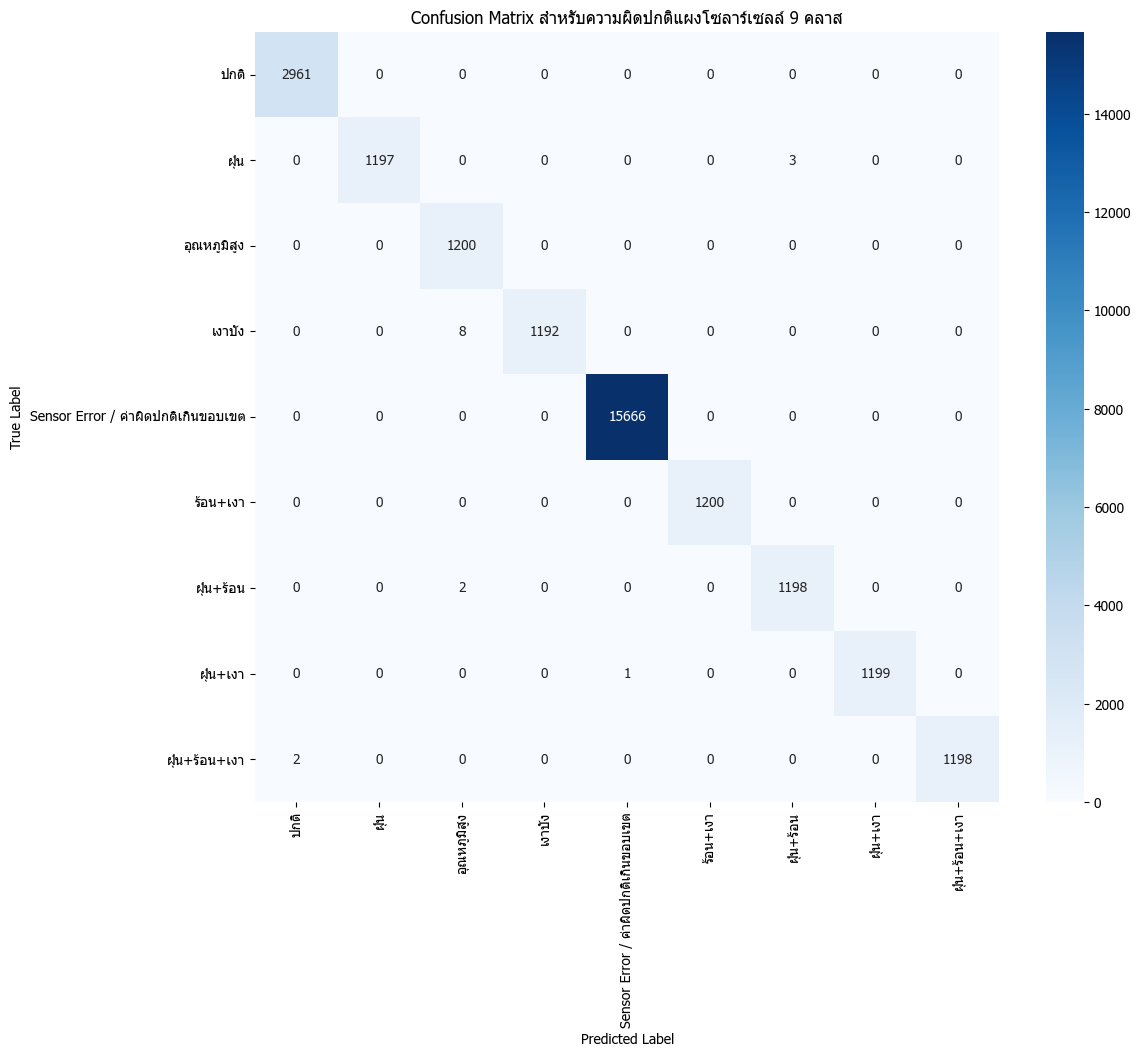

In [3]:
# ===================================================================================
# 3) MODEL EVALUATION AND REPORTING
# ===================================================================================

print("\n" + "="*50)
print("--- 3) Model Evaluation ---")
print("="*50)

labels_to_show = np.arange(NUM_EXPECTED_CLASSES)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}") 

# Classification Report
y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report (ความแม่นยำของแต่ละ Class):")
print(classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=list(AI_CLASS_MAPPING.values()), 
    labels=labels_to_show,
    zero_division=0
))

# Confusion Matrix Plot
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=labels_to_show)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(AI_CLASS_MAPPING.values()), 
            yticklabels=list(AI_CLASS_MAPPING.values()))
plt.title('Confusion Matrix สำหรับความผิดปกติแผงโซลาร์เซลล์ 9 คลาส')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [4]:
# ===================================================================================
# 4) ENHANCED DIAGNOSIS FUNCTION (Function for Production Use) - ปรับปรุง
# ===================================================================================

def enhanced_solar_diagnosis(volt: float, temp: float, dust: float, light: float, model: keras.Model, scaler: StandardScaler) -> Dict[str, Any]:
    """
    ทำการวิเคราะห์เชิงลึกโดยเปรียบเทียบค่าเซ็นเซอร์กับเกณฑ์ และส่งคืนผลวินิจฉัย
    พร้อมค่าความน่าจะเป็น (Probabilities) ของทุก 9 Classes
    """
    
    # 1. ทำนายผลด้วย AI Model
    input_data = np.array([[volt, temp, dust, light]])
    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled, verbose=0)
    
    # ดึงค่าความน่าจะเป็นของแต่ละคลาส (9 ค่า)
    probabilities = prediction[0]
    ai_predicted_class = np.argmax(probabilities)
    
    # สร้าง Dict ของความน่าจะเป็นตามชื่อ Class
    prob_output = {}
    for i in range(NUM_EXPECTED_CLASSES):
        prob_output[AI_CLASS_MAPPING[i]] = float(probabilities[i])
    
    
    abnormal_values: Dict[str, str] = {}
    cause_analysis: list[str] = []
    
    # 2. Rule-Based Analysis (เหมือนเดิม)
    is_dusty = dust > DUST_HIGH_THRESHOLD
    is_hot = temp > TEMP_HIGH_THRESHOLD
    is_shady = light < LIGHT_LOW_THRESHOLD
    is_night = light < 10

    # ตรวจสอบ Volt เพื่อรายงาน
    if volt < VOLT_LOW_THRESHOLD and not is_night:
        abnormal_values['แรงดัน (Volt)'] = f"ต่ำกว่าเกณฑ์ ({volt:.2f}V)"
        cause_analysis.append(f"**แรงดันไฟฟ้าต่ำ:** บ่งชี้ถึงการผลิตพลังงานที่ไม่เต็มที่")
    elif volt > 18.0: 
        abnormal_values['แรงดัน (Volt)'] = f"สูงผิดปกติ ({volt:.2f}V)"
        cause_analysis.append(f"**แรงดันไฟฟ้าสูงผิดปกติ:** มีความเสี่ยงเป็น Sensor Error (Class 4)")
        
    # ตรวจสอบอุณหภูมิ (Temp)
    if is_hot:
        abnormal_values['อุณหภูมิ (Temp)'] = f"สูงกว่าเกณฑ์ ({temp:.2f}°C)"
        cause_analysis.append(f"**อุณหภูมิแผงสูงเกินไป:** ทำให้ประสิทธิภาพลดลง")

    # ตรวจสอบฝุ่น (Dust)
    if is_dusty:
        abnormal_values['ฝุ่น (Dust)'] = f"สูงกว่าเกณฑ์ ({dust:.2f} ug/m3)"
        cause_analysis.append(f"**ระดับฝุ่นสูง:** แผงสกปรก ควรล้างเพื่อลดการสูญเสียพลังงาน")

    # ตรวจสอบแสง (Irradiance/Light)
    if is_shady and not is_night: 
        cause_analysis.append(f"**แสงน้อย:** ค่าแสงต่ำ ({light:.2f} Lux) เมื่อเทียบกับช่วงกลางวัน บ่งชี้ว่าอาจมี **เงาบัง**")
    elif is_night:
        cause_analysis.append(f"**แสงน้อยมาก:** ค่าแสงต่ำกว่า 10 Lux บ่งชี้ว่าเป็นช่วง **กลางคืน/ค่ำมืด**")

    # 3. สรุปผลลัพธ์
    ai_label = AI_CLASS_MAPPING.get(ai_predicted_class, "รหัสความผิดปกติที่ไม่รู้จัก")
    
    if ai_predicted_class == 0:
        summary = "✅ **ผลลัพธ์: ระบบอยู่ในสถานะปกติ** (ทุกค่าเซ็นเซอร์อยู่ในเกณฑ์ที่กำหนด)"
    else:
        summary = f"🚨 **สรุปผลวินิจฉัย: {ai_label}**\n\n"
        
        if ai_predicted_class == 4:
            summary += "### 1. การวินิจฉัย Class 4 (Sensor/Internal Error):\n"
            if (volt < VOLT_CRITICAL_LOW and not is_dusty and not is_hot and not is_shady and not is_night):
                 summary += f" - **สาเหตุ:** **Sensor Error/Internal Fault** (ค่า Volt ต่ำมาก [{volt:.2f}V] แต่ปัจจัยภายนอกปกติ)\n"
            else:
                 summary += " - **สาเหตุ:** **Physical/Sensor Error** (ค่าเซ็นเซอร์หนึ่งหรือหลายตัวผิดปกติเกินขีดจำกัดทางกายภาพ)\n"
        else:
            summary += "### 1. รายการค่าที่ข้ามเกณฑ์:\n"
            if abnormal_values:
                for sensor, value_status in abnormal_values.items():
                    summary += f"- **{sensor}:** {value_status}\n"
            else:
                 summary += "- ไม่พบค่าเซ็นเซอร์ใดที่ข้ามเกณฑ์เดี่ยวๆ\n"
            
            summary += "\n### 2. การวิเคราะห์สาเหตุเชิงลึกและข้อเสนอแนะ:\n"
            for cause in cause_analysis:
                summary += f" - {cause}\n"
        
    # ส่งคืน Dictionary ที่รวมทั้งผลสรุปและ Probabilities
    return {
        "predicted_class": ai_predicted_class,
        "predicted_label": ai_label,
        "summary_report": summary,
        "probabilities": prob_output
    }

In [5]:
# ===================================================================================
# 5) EXAMPLE DIAGNOSIS (TESTING THE FUNCTION) - ปรับปรุงการแสดงผล
# ===================================================================================

print("\n" + "="*70)
print("--- 5) ตัวอย่างการใช้งานจริงเพื่อวินิจฉัยด้วยโมเดลที่ฝึกเสร็จแล้ว ---")
print("="*70)

def display_diagnosis_result(result: Dict[str, Any]):
    """ฟังก์ชันช่วยแสดงผลลัพธ์การวินิจฉัยอย่างสวยงาม"""
    print(result['summary_report'])
    print("\n[ค่าความน่าจะเป็นของแต่ละ Class (9 Classes)]")
    
    # เรียงลำดับจากความน่าจะเป็นสูงสุดไปต่ำสุด
    sorted_probs = sorted(result['probabilities'].items(), key=lambda item: item[1], reverse=True)
    
    for label, prob in sorted_probs:
        prob_percent = prob * 100
        print(f"- {label:<30}: {prob_percent:6.2f}% (Predicted Class: {result['predicted_label'] == label})")
    print("-" * 30)


# สถานการณ์ที่ 1: Sensor Error (Volt 3V, แสง 800 Lux) -> ควรเป็น Class 4
print("### สถานการณ์ที่ 1: Sensor Error (Volt 3V, แสง 800 Lux) ###")
volt_test1 = 3.0
temp_test1 = 35.0
dust_test1 = 50.0
light_test1 = 800.0

diagnosis_result1 = enhanced_solar_diagnosis(
    volt=volt_test1, temp=temp_test1, dust=dust_test1, light=light_test1, 
    model=model, scaler=scaler
)
display_diagnosis_result(diagnosis_result1)


# สถานการณ์ที่ 2: ฝุ่น + ร้อน + เงา (Worst Case) -> Class 8
print("\n" + "-"*30)
print("### สถานการณ์ที่ 2: ฝุ่น (160) + ร้อน (55) + เงา (100) ###")
volt_test2 = 12.0
temp_test2 = 55.0
dust_test2 = 160.0
light_test2 = 100.0

diagnosis_result2 = enhanced_solar_diagnosis(
    volt=volt_test2, temp=temp_test2, dust=dust_test2, light=light_test2, 
    model=model, scaler=scaler
)
display_diagnosis_result(diagnosis_result2)


--- 5) ตัวอย่างการใช้งานจริงเพื่อวินิจฉัยด้วยโมเดลที่ฝึกเสร็จแล้ว ---
### สถานการณ์ที่ 1: Sensor Error (Volt 3V, แสง 800 Lux) ###
🚨 **สรุปผลวินิจฉัย: ฝุ่น**

### 1. รายการค่าที่ข้ามเกณฑ์:
- **แรงดัน (Volt):** ต่ำกว่าเกณฑ์ (3.00V)

### 2. การวิเคราะห์สาเหตุเชิงลึกและข้อเสนอแนะ:
 - **แรงดันไฟฟ้าต่ำ:** บ่งชี้ถึงการผลิตพลังงานที่ไม่เต็มที่


[ค่าความน่าจะเป็นของแต่ละ Class (9 Classes)]
- ฝุ่น                          : 100.00% (Predicted Class: True)
- ฝุ่น+ร้อน                     :   0.00% (Predicted Class: False)
- เงาบัง                        :   0.00% (Predicted Class: False)
- อุณหภูมิสูง                   :   0.00% (Predicted Class: False)
- ฝุ่น+เงา                      :   0.00% (Predicted Class: False)
- Sensor Error / ค่าผิดปกติเกินขอบเขต:   0.00% (Predicted Class: False)
- ฝุ่น+ร้อน+เงา                 :   0.00% (Predicted Class: False)
- ร้อน+เงา                      :   0.00% (Predicted Class: False)
- ปกติ                          :   0.00% (Predicted Class: False)
-------

In [6]:
# ===================================================================================
# 6) RE-EVALUATION ON TEST SET (1000+ SAMPLES)
# ===================================================================================

print("\n" + "="*70)
print("--- 6) การประเมินผลประสิทธิภาพบนชุดข้อมูลทดสอบ (Test Set) ---")
print(f"จำนวนตัวอย่างที่ใช้ทดสอบ: {X_test.shape[0]} ตัวอย่าง")
print("="*70)

# 1. ประเมินผลหลัก
# X_test และ y_test ถูกกำหนดไว้ในส่วนที่ 1
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nสรุปผล:")
print(f"Test Loss (ค่าความผิดพลาด): {loss:.4f}")
print(f"Test Accuracy (ความแม่นยำรวม): {accuracy:.4f}")

# 2. Classification Report (แสดงความแม่นยำของแต่ละคลาส)

# กำหนด Labels ทั้งหมดที่คาดหวัง (0 ถึง 8) 
labels_to_show = np.arange(NUM_EXPECTED_CLASSES)

y_pred_probs = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report (รายละเอียดความแม่นยำแต่ละ Class):")
print(classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=list(AI_CLASS_MAPPING.values()), 
    labels=labels_to_show,
    zero_division=0
))


--- 6) การประเมินผลประสิทธิภาพบนชุดข้อมูลทดสอบ (Test Set) ---
จำนวนตัวอย่างที่ใช้ทดสอบ: 27027 ตัวอย่าง
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.9994 - loss: 0.0016

สรุปผล:
Test Loss (ค่าความผิดพลาด): 0.0016
Test Accuracy (ความแม่นยำรวม): 0.9994

Classification Report (รายละเอียดความแม่นยำแต่ละ Class):
                                     precision    recall  f1-score   support

                               ปกติ       1.00      1.00      1.00      2961
                               ฝุ่น       1.00      1.00      1.00      1200
                        อุณหภูมิสูง       0.99      1.00      1.00      1200
                             เงาบัง       1.00      0.99      1.00      1200
Sensor Error / ค่าผิดปกติเกินขอบเขต       1.00      1.00      1.00     15666
                           ร้อน+เงา       1.00      1.00      1.00      1200
                          ฝุ่น+ร้อน       1.00      1.00      1.00      1200
                           ฝุ่น+เงา       1.00      1.00      